# Section 0: Setup

**Note: If you want to run this code you must get an API Key from FRED.**

In [ ]:

from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose


# Section 1: Load Data

In [2]:
EGG_SERIES_ID = "APU0000708111"

df = fred.get_series(EGG_SERIES_ID)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# The data is missing October so we remove October 2025 and November 2025 to avoid the gap
df = df.loc[df.index <= "2025-09-01"]

# Now the index is perfectly regular monthly
df = df.asfreq("MS")



df.index.name = "date"


df = (
    df.to_frame("price_usd")
      .sort_index()
      .dropna()
)


In [3]:
df.head()

,price_usd
date,
1980-01-01,0.879
1980-02-01,0.774
1980-03-01,0.812
1980-04-01,0.797
1980-05-01,0.737


# Section 2: Visual EDA

<Axes: title={'center': 'Average Price of df (USD per dozen)'}, xlabel='Date', ylabel='Price'>

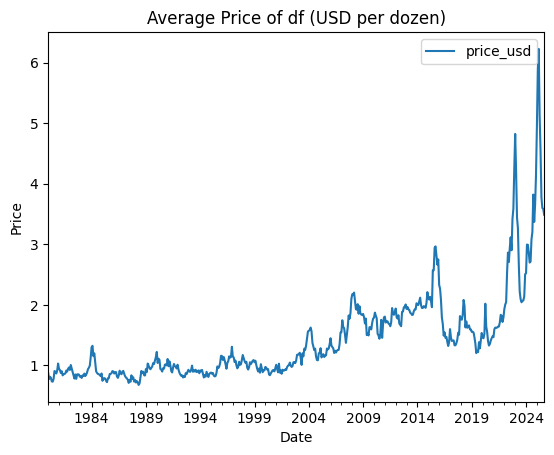

In [4]:
# visualize the raw data
df.plot(title="Average Price of df (USD per dozen)", xlabel="Date", ylabel="Price")

In [5]:
rolling_mean = df['price_usd'].rolling(12).mean()
rolling_std = df['price_usd'].rolling(12).std()

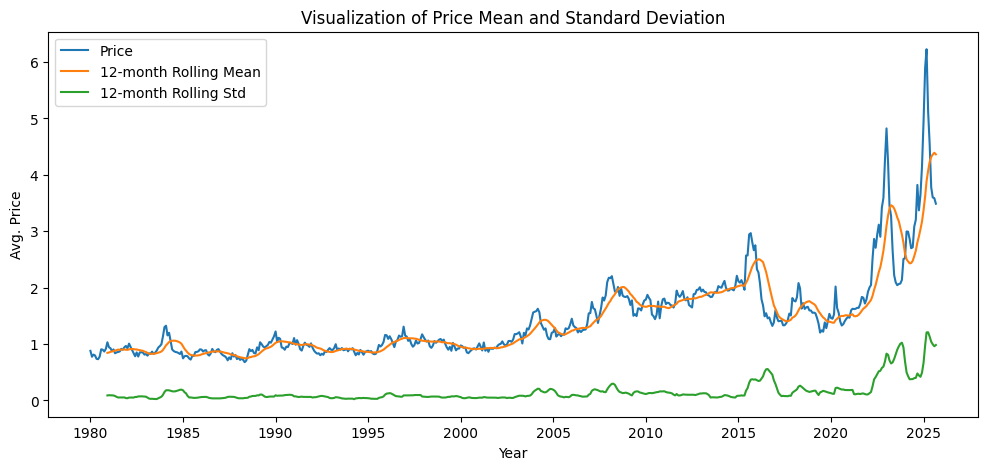

In [6]:
plt.figure(figsize=(12,5))
plt.plot(df["price_usd"], label="Price")
plt.plot(rolling_mean, label="12-month Rolling Mean")
plt.plot(rolling_std, label="12-month Rolling Std")
plt.title('Visualization of Price Mean and Standard Deviation')
plt.xlabel("Year")
plt.ylabel("Avg. Price")
plt.legend()

Prices trend upward over time and show increasing volatility, indicating non-stationarity.

# Section 3: Transformations

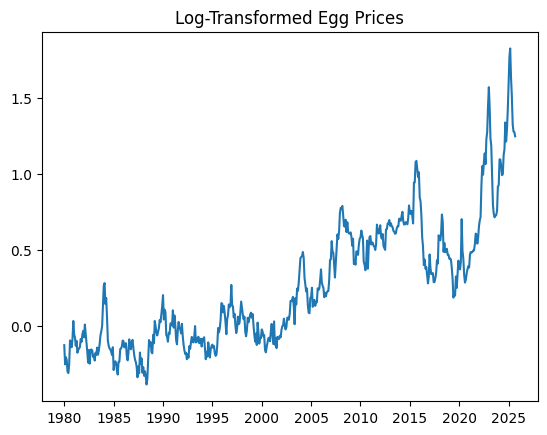

In [7]:
df['log_price'] = np.log(df['price_usd'])
plt.figure()
plt.plot(df.index, df['log_price'])
plt.title("Log-Transformed Egg Prices")
plt.show()


<Axes: title={'center': 'Log of Average Price Difference of Eggs (USD per dozen)'}, xlabel='Date', ylabel='Log Change in Price'>

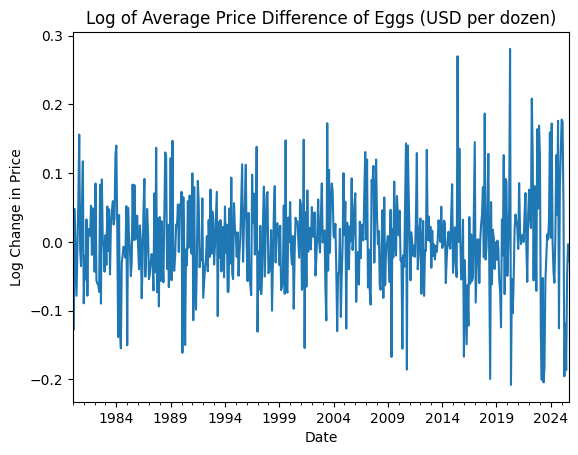

In [8]:
df['log_diff_1'] = df['log_price'].diff()
df['log_diff_1'].plot(title="Log of Average Price Difference of Eggs (USD per dozen)", xlabel="Date", ylabel="Log Change in Price")


<Axes: title={'center': 'Egg Price Changes After Accounting for Trend and Seasonality'}, xlabel='Date', ylabel='Log Change in Price'>

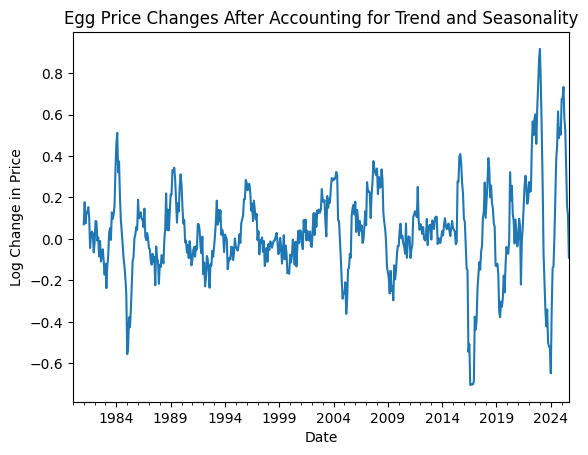

In [9]:
df['log_diff_12'] = df['log_price'].diff(12)
df['log_diff_12'].plot(title="Egg Price Changes After Accounting for Trend and Seasonality", xlabel="Date", ylabel="Log Change in Price")

A log transform stabilizes variance, and first and seasonal differencing remove trend and annual seasonality. These steps are necessary for ARIMA-style models.

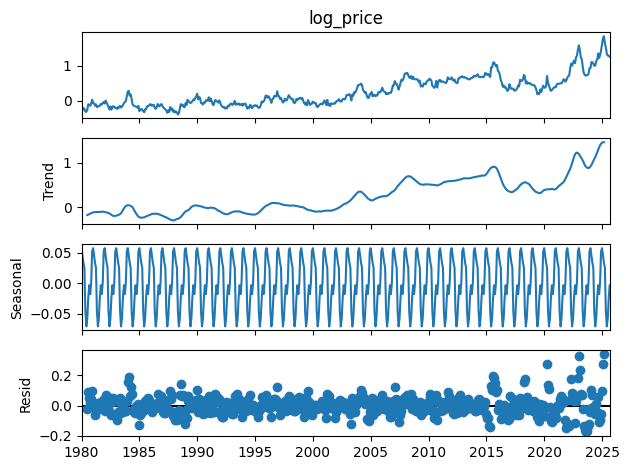

In [10]:
decomp = seasonal_decompose(df['log_price'], model='additive', period=12)
decomp.plot()
plt.show()

# Section 4: Stationarity Checks

In [11]:
def run_adfuller(series):
    series = series.dropna()
    stat, pval, lags, nobs, *_ = adfuller(series)
    return pd.Series([stat, pval, lags, nobs],
                     index=["ADF Statistic", "p-value", "# Lags Used", "# Observations"])


In [12]:
adf_table = pd.DataFrame({
    "Raw Price": run_adfuller(df["price_usd"]),
    "Log Price": run_adfuller(df["log_price"]),
    "Log Diff (1)": run_adfuller(df["log_diff_1"]),
    "Log Diff (12)": run_adfuller(df["log_diff_12"]),
}).T

In [13]:
adf_table

,ADF Statistic,p-value,# Lags Used,# Observations
Raw Price,0.714590,9.901246e-01,18.0,530.0
Log Price,0.133476,9.682737e-01,18.0,530.0
Log Diff (1),-8.083500,1.440295e-12,17.0,530.0
Log Diff (12),-5.507247,2.008945e-06,17.0,519.0


After first and seasonal differencing, the series is stationary, justifying SARIMA.

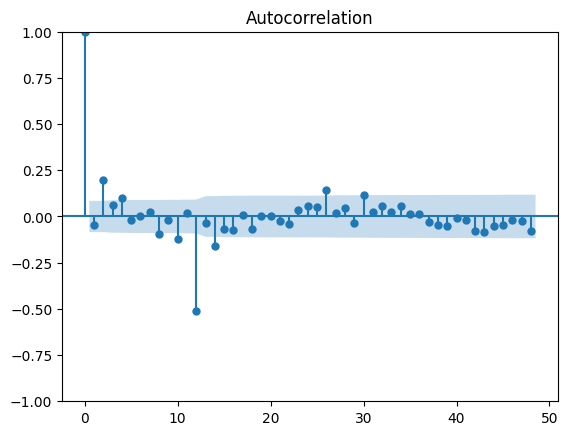

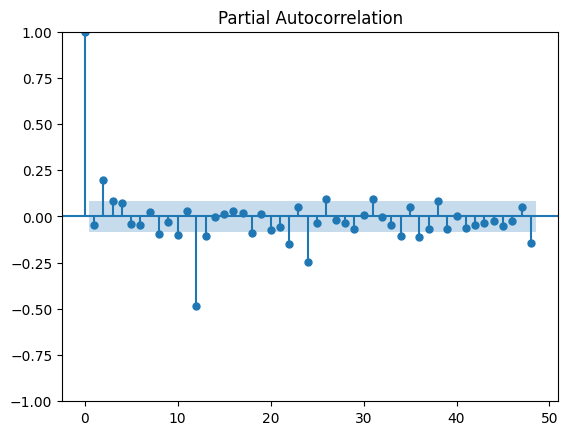

In [14]:
series = (
    (df['log_price'])
    .diff()
    .diff(12)
    .dropna()
)

sm.graphics.tsa.plot_acf(series, lags=48)
sm.graphics.tsa.plot_pacf(series, lags=48)
plt.show()


# Section 5: Modeling

I compare ARIMA and SARIMA specifications and select a seasonal model based on information criteria and residual behavior.

In [15]:
model_arima = ARIMA(
    df["log_price"],
    order=(1,1,1),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_arima = model_arima.fit()
print(results_arima.summary())


                               SARIMAX Results                                
Dep. Variable:              log_price   No. Observations:                  549
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 670.733
Date:                Wed, 31 Dec 2025   AIC                          -1335.467
Time:                        15:21:32   BIC                          -1322.559
Sample:                    01-01-1980   HQIC                         -1330.421
                         - 09-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5027      0.483     -1.040      0.298      -1.450       0.444
ma.L1          0.4641      0.492      0.943      0.345      -0.500       1.428
sigma2         0.0050      0.000     20.531      0.0

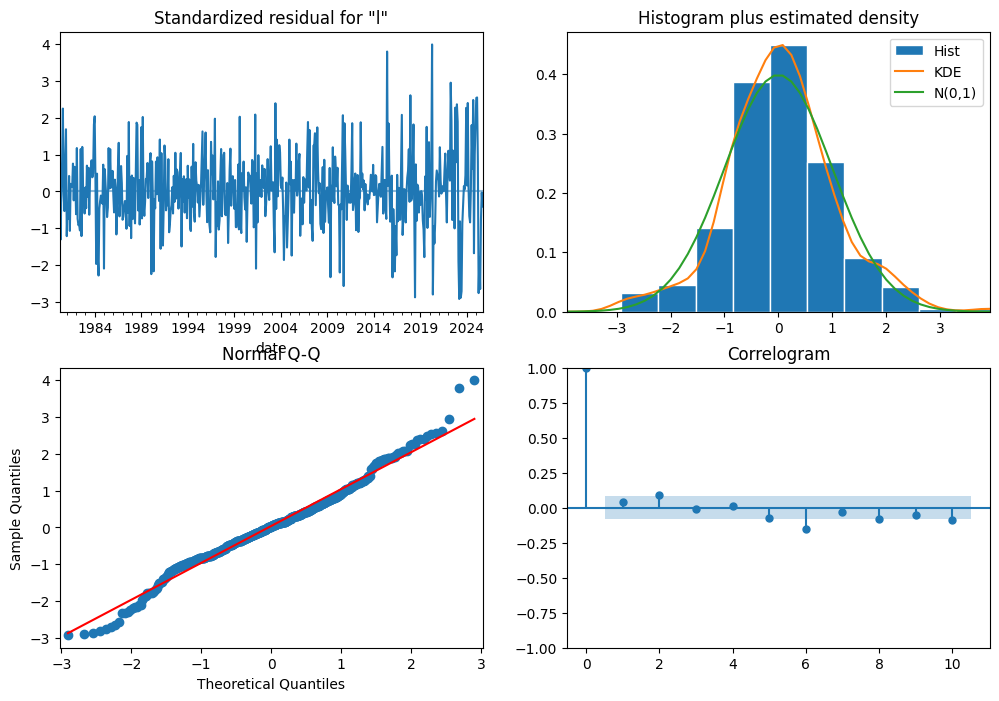

In [16]:
results_arima.plot_diagnostics(figsize=(12,8))
plt.show()

                                     SARIMAX Results                                      
Dep. Variable:                          log_price   No. Observations:                  549
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 671.738
Date:                            Wed, 31 Dec 2025   AIC                          -1337.477
Time:                                    15:21:33   BIC                          -1324.704
Sample:                                01-01-1980   HQIC                         -1332.474
                                     - 09-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0643      0.038     -1.711      0.087      -0.138       0.009
ma.S.L12      -0.9472      0.026   

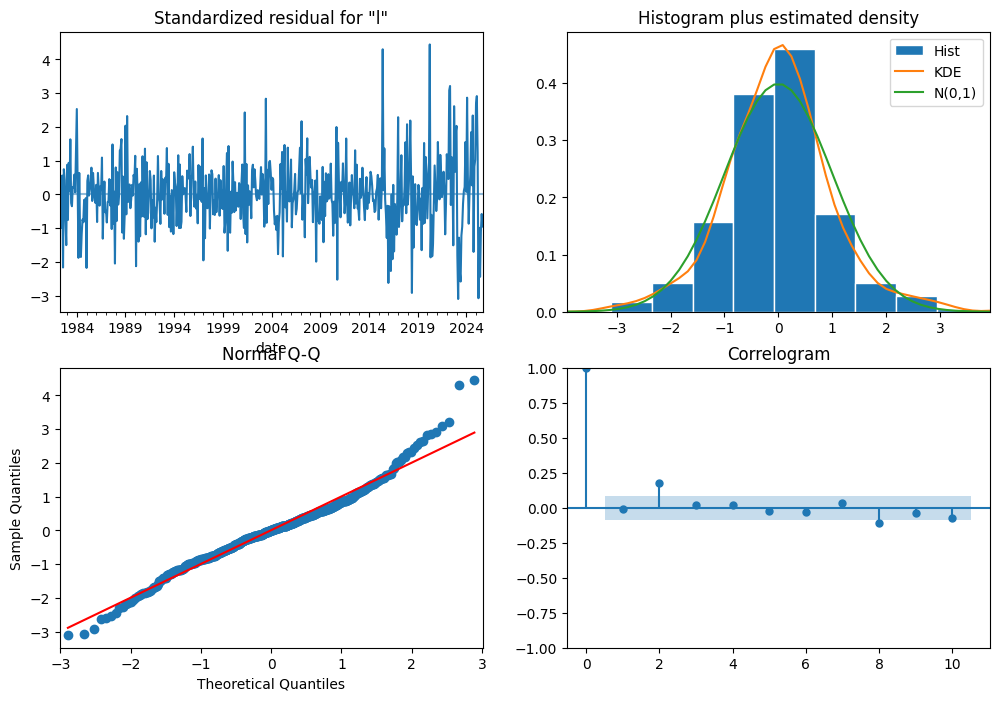

In [17]:
# (0,1,1)x(0,1,1,12)
model_sarima = SARIMAX(
    df["log_price"],
    order=(0,1,1),
    seasonal_order=(0,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarima = model_sarima.fit()
print(results_sarima.summary())
results_sarima.plot_diagnostics(figsize=(12,8))
plt.show()

                                     SARIMAX Results                                      
Dep. Variable:                          log_price   No. Observations:                  549
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 673.906
Date:                            Wed, 31 Dec 2025   AIC                          -1337.813
Time:                                    15:21:34   BIC                          -1316.525
Sample:                                01-01-1980   HQIC                         -1329.475
                                     - 09-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5235      0.237     -2.213      0.027      -0.987      -0.060
ma.L1          0.4086      0.248   

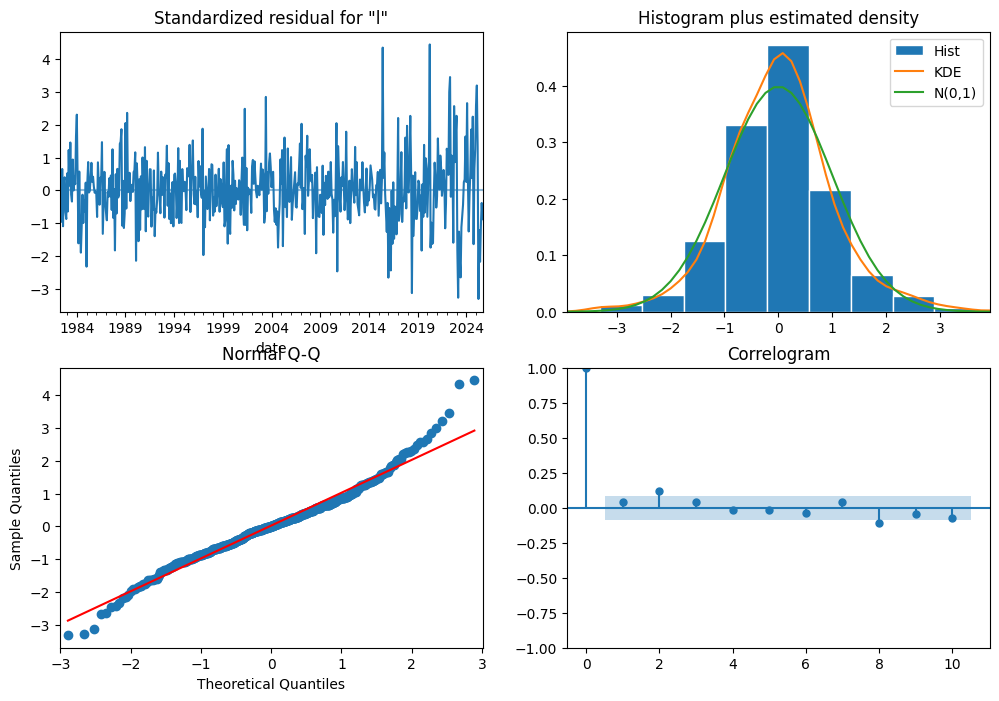

In [18]:
# (1,1,1)x(1,1,1,12)
model_sarima_2 = SARIMAX(
    df["log_price"],
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarima_2 = model_sarima_2.fit()
print(results_sarima_2.summary())
results_sarima_2.plot_diagnostics(figsize=(12,8))
plt.show()

                                     SARIMAX Results                                      
Dep. Variable:                          log_price   No. Observations:                  549
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 690.052
Date:                            Wed, 31 Dec 2025   AIC                          -1370.105
Time:                                    15:21:35   BIC                          -1348.703
Sample:                                01-01-1980   HQIC                         -1361.730
                                     - 09-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5630      0.215     -2.622      0.009      -0.984      -0.142
ma.L1          0.4541      0.228   

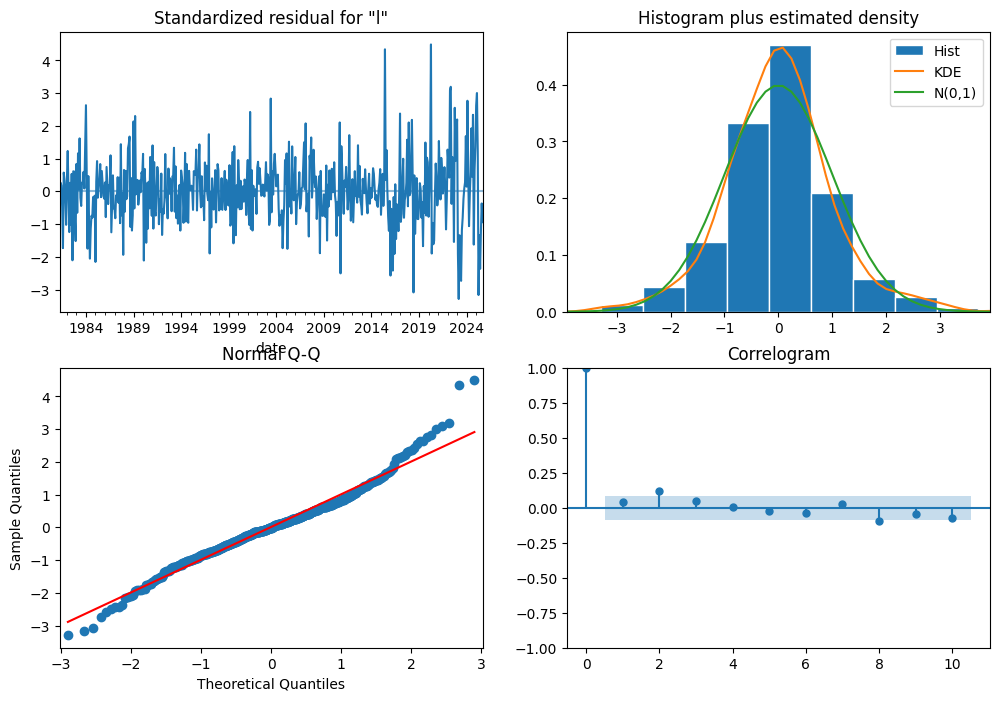

In [19]:
# (1,1,1)x(1,0,1,12)
model_sarima_3 = SARIMAX(
    df["log_price"],
    order=(1,1,1),
    seasonal_order=(1,0,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarima_3 = model_sarima_3.fit()
print(results_sarima_3.summary())
results_sarima_3.plot_diagnostics(figsize=(12,8))
plt.show()

                                      SARIMAX Results                                       
Dep. Variable:                            log_price   No. Observations:                  549
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 673.651
Date:                              Wed, 31 Dec 2025   AIC                          -1341.303
Time:                                      15:21:35   BIC                          -1328.524
Sample:                                  01-01-1980   HQIC                         -1336.298
                                       - 09-01-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0865      0.038     -2.249      0.025      -0.162      -0.011
ma.S.L12      -0.94

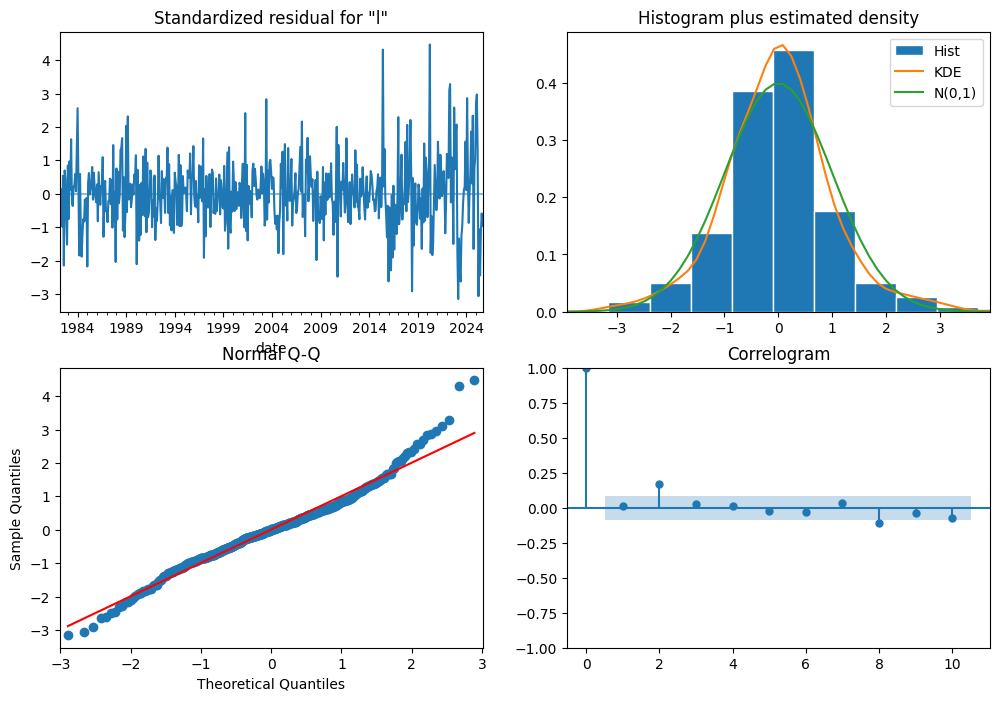

In [20]:
# (1,1,0)x(0,1,1,12)
model_sarima_4 = SARIMAX(
    df["log_price"],
    order=(1,1,0),
    seasonal_order=(0,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarima_4 = model_sarima_4.fit()
print(results_sarima_4.summary())
results_sarima_4.plot_diagnostics(figsize=(12,8))
plt.show()

In [21]:
print("ARIMA  AIC:", results_arima.aic, "BIC:", results_arima.bic)
print("SARIMA (0,1,1)x(0,1,1,12) AIC:", results_sarima.aic, "BIC:", results_sarima.bic)
print("SARIMA (1,1,1)x(1,1,1,12) AIC:", results_sarima_2.aic, "BIC:", results_sarima_2.bic)
print("SARIMA (0,1,1)x(1,0,1,12) AIC:", results_sarima_3.aic, "BIC:", results_sarima_3.bic)
print("SARIMA (1,1,0)x(0,1,1,12) AIC:", results_sarima_4.aic, "BIC:", results_sarima_4.bic)


ARIMA  AIC: -1335.4665872155574 BIC: -1322.5587302883227
SARIMA (0,1,1)x(0,1,1,12) AIC: -1337.4769161841502 BIC: -1324.7039134205024
SARIMA (1,1,1)x(1,1,1,12) AIC: -1337.812858312011 BIC: -1316.5245203725979
SARIMA (0,1,1)x(1,0,1,12) AIC: -1370.1046294099237 BIC: -1348.7026502151227
SARIMA (1,1,0)x(0,1,1,12) AIC: -1341.3025156566623 BIC: -1328.5237712644675


A seasonal model offers a slight improvement in fit, but the gains are small. This reflects that recent egg price dynamics are driven more by shocks than by stable seasonal patterns.

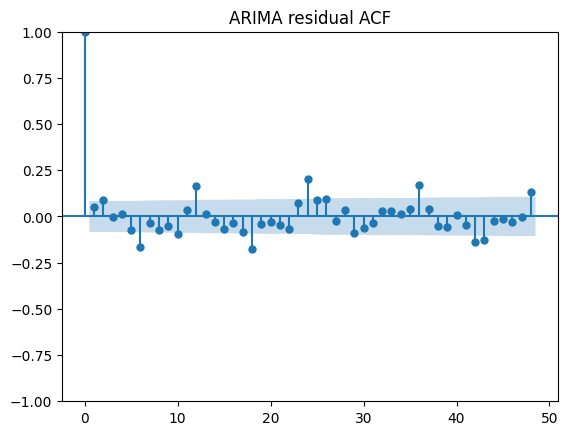

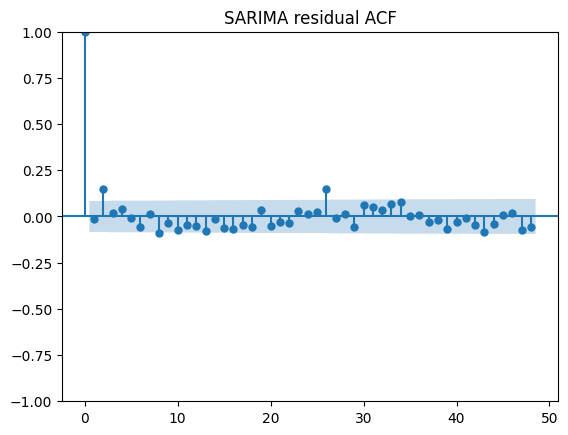

In [22]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

sm.graphics.tsa.plot_acf(results_arima.resid.dropna(), lags=48)
plt.title("ARIMA residual ACF")
plt.show()

sm.graphics.tsa.plot_acf(results_sarima.resid.dropna(), lags=48)
plt.title("SARIMA residual ACF")
plt.show()


# Section 6: Out-of-Sample Forecast

In [23]:
train = df.loc[: "2019-12-01"].copy()
test  = df.loc["2020-01-01":].copy()


In [24]:
model = SARIMAX(
    train["log_price"],
    order=(1,1,1),
    seasonal_order=(1,0,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
res = model.fit(disp=False)


In [25]:
n_test = len(test)
forecast_res = res.get_forecast(steps=n_test)

forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

# Put forecast on the same index as test
forecast_mean.index = test.index
forecast_ci.index = test.index


In [26]:
# --- Baselines (price space) ---
naive_pred = test["price_usd"].shift(1)
snaive_pred = test["price_usd"].shift(12)

# --- Convert SARIMA forecast to price space ---
sarima_price_naive = np.exp(forecast_mean)

forecast_var = forecast_res.var_pred_mean
forecast_var.index = test.index
sarima_price_bc = np.exp(forecast_mean + 0.5 * forecast_var)


In [27]:
comparison = pd.DataFrame({
    "Actual": test["price_usd"],
    "SARIMA": sarima_price_naive,
    "SARIMA (bias-corrected)": sarima_price_bc,
    "Naive (Last Value)": naive_pred,
    "Seasonal Naive (Last Year)": snaive_pred
})

In [28]:
def compute_mae(y_true, y_pred):
    """Compute MAE after aligning and dropping NaNs / infs."""
    mask = (
        y_true.notna()
        & y_pred.notna()
        & ~np.isinf(y_true)
        & ~np.isinf(y_pred)
    )
    return mean_absolute_error(y_true[mask], y_pred[mask])

mae = {
    "SARIMA": compute_mae(
        comparison["Actual"],
        comparison["SARIMA"]
    ),
    "SARIMA (bias-corrected)": compute_mae(
        comparison["Actual"],
        comparison["SARIMA (bias-corrected)"]
    ),

    "Naive (Last Value)": compute_mae(
        comparison["Actual"].iloc[1:],
        comparison["Naive (Last Value)"].iloc[1:]
    ),
    "Seasonal Naive (Last Year)": compute_mae(
        comparison["Actual"].iloc[12:],
        comparison["Seasonal Naive (Last Year)"].iloc[12:]
    ),
}

print("MAE (USD per dozen) — Test period (2020+):")
for model, score in mae.items():
    print(f"{model:30s} {score:6.2f}")


MAE (USD per dozen) — Test period (2020+):
SARIMA                           1.18
SARIMA (bias-corrected)          1.12
Naive (Last Value)               0.25
Seasonal Naive (Last Year)       1.06


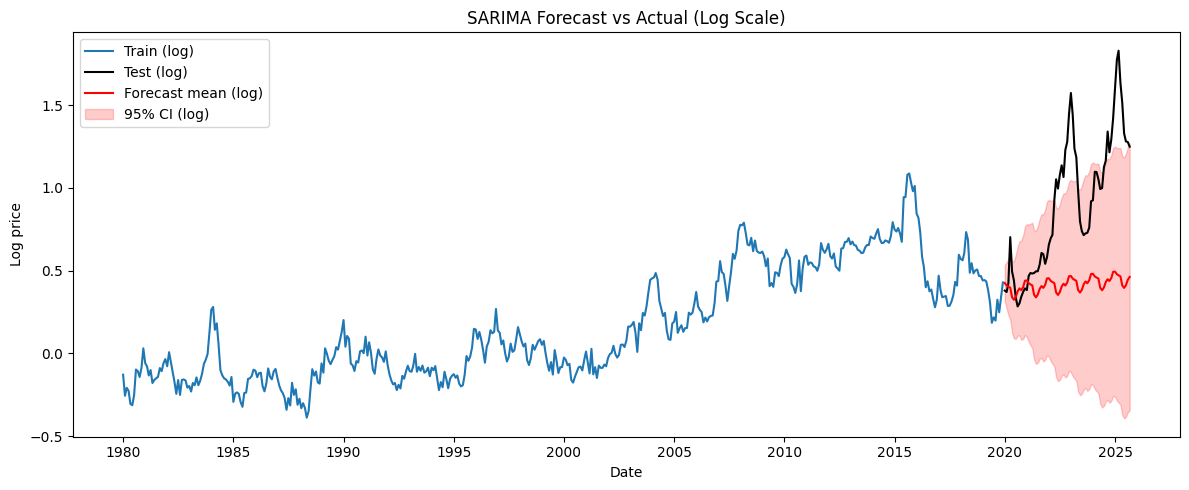

In [31]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train["log_price"], label="Train (log)")
plt.plot(test.index, test["log_price"], label="Test (log)", color="black")
plt.plot(forecast_mean.index, forecast_mean, label="Forecast mean (log)", color="red")
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    alpha=0.2,
    label="95% CI (log)",
    color = 'red'
)
plt.title("SARIMA Forecast vs Actual (Log Scale)")
plt.xlabel("Date")
plt.ylabel("Log price")
plt.legend()
plt.tight_layout()
plt.show()


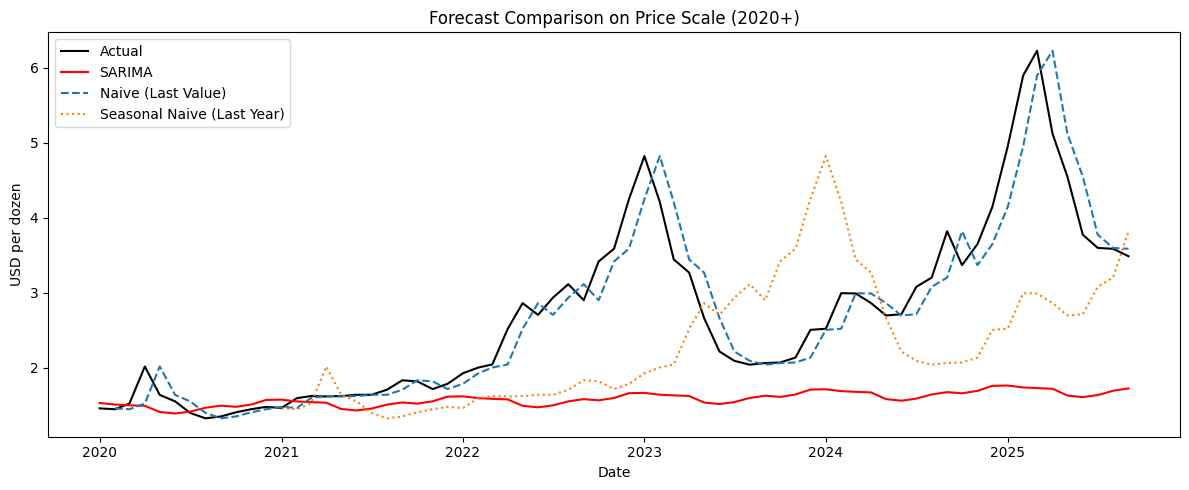

In [32]:
plt.figure(figsize=(12,5))
plt.plot(comparison["Actual"], label="Actual", color="black")
plt.plot(comparison["SARIMA (bias-corrected)"], label="SARIMA", color="red")
plt.plot(comparison["Naive (Last Value)"], label="Naive (Last Value)", linestyle="--")
plt.plot(comparison["Seasonal Naive (Last Year)"], label="Seasonal Naive (Last Year)", linestyle=":")
plt.title("Forecast Comparison on Price Scale (2020+)")
plt.xlabel("Date")
plt.ylabel("USD per dozen")
plt.legend()
plt.tight_layout()
plt.show()

The SARIMA model produces a smooth baseline forecast but fails to anticipate large post-2020 price spikes. During shock-dominated periods, a simple last-value baseline performs better on one-step-ahead error by immediately absorbing level shifts. This example illustrates that forecasting performance depends as much on market structure and regime stability as on model choice.